In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from fbprophet import Prophet
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

# Initialize Spark Session
## we are telling like to run a spark session in a local mode and assign it to an object. when we run this in a cluster mode then we can distribute the thousands of products across hundreds of nodes for fast query execution. 

In [2]:
import findspark
findspark.init('C:/spark/spark-3.0.3-bin-hadoop2.7/')

In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local').getOrCreate()

Exception: Java gateway process exited before sending its port number

In [4]:
df = pd.read_csv("Utilized_data.csv")
df.shape

(882, 5)

In [5]:
df.head()

,Date,LOC,RING,Sold_bandwidth,Utilized_bandwidth
0,15-06-2021,chennai to kadappa,EIR,114.2,9.7
1,15-06-2021,chennai to chennai vsb,EIR,119.1,1.9
2,15-06-2021,chennai to hyderabad,EIR,106.9,0.4
3,15-06-2021,hyderabad to kadappa 1,GCIR,116.8,4.5
4,15-06-2021,kadappa to mumbai,GCIR,72.7,5.4


# Basic Preprocessing
## The first is to convert the date column from string type to Date type. After that let us check that is there any missing values and how many unique values we have in each column? Basically when we are running a Multiple time series then we are going to treat each LOC as separate time series so we are going to build 21 different models over here.

In [6]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [7]:
print("Features:\n", df.columns)
print("\nMissing values - \n", df.isnull().any())
print("\nUnique values: \n", df.nunique())

Features:
 Index(['Date', 'LOC', 'RING', 'Sold_bandwidth', 'Utilized_bandwidth'], dtype='object')

Missing values - 
 Date                  False
LOC                   False
RING                  False
Sold_bandwidth        False
Utilized_bandwidth     True
dtype: bool

Unique values: 
 Date                   42
LOC                    21
RING                    7
Sold_bandwidth        238
Utilized_bandwidth    150
dtype: int64


In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
df[['LOC', 'RING']] = df[['LOC', 'RING']].apply(LabelEncoder().fit_transform)


In [10]:
df.head()

,Date,LOC,RING,Sold_bandwidth,Utilized_bandwidth
0,2021-06-15,3,0,114.2,9.7
1,2021-06-15,1,0,119.1,1.9
2,2021-06-15,2,0,106.9,0.4
3,2021-06-15,10,1,116.8,4.5
4,2021-06-15,16,1,72.7,5.4


In [11]:
df['Utilized_bandwidth'].fillna(df['Utilized_bandwidth'].mean(), inplace = True)


In [12]:
df.isna().sum()

Date                  0
LOC                   0
RING                  0
Sold_bandwidth        0
Utilized_bandwidth    0
dtype: int64

# Visualize the Time-series data
## Now to visualize the time-series data of each location we are setting the date as an index and plot the graph for a location.

In [13]:
df.LOC.unique()

array([ 3,  1,  2, 10, 16, 13, 11, 17,  5,  7,  8,  9, 19,  4, 20, 15, 14,
        0, 18, 12,  6])

for i in range(1,22):
    item_df = df.set_index('Date')
    item_df.query('LOC == "{i}" ')[['Sold_bandwidth', 'Utilized_bandwidth']].plot()
    plt.show()

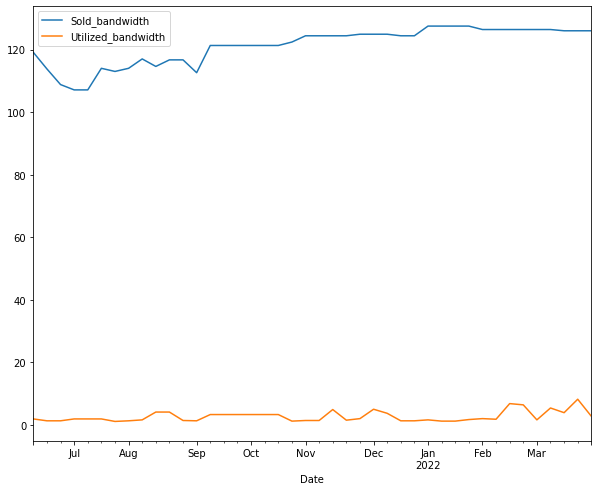

In [14]:
item_df = df.set_index('Date')
item_df.query('LOC == 1')[['Sold_bandwidth', 'Utilized_bandwidth']].plot()
plt.show()

In [15]:
df.isna().sum()

Date                  0
LOC                   0
RING                  0
Sold_bandwidth        0
Utilized_bandwidth    0
dtype: int64

# Analyze the Dataset with Spark
## Spark DataFrame

## We have Pandas Dataframe and we have analyzed it. Now we will create a spark component so we will create a Spark DataFrame. you can also print schema of it to see the data type of columns. count function is used to count the rows in the dataset.

In [16]:
sdf = spark.createDataFrame(df)
sdf.printSchema() #data type of each col
sdf.show(5) #It gives you head of pandas DataFrame
sdf.count() #500 records

root
 |-- Date: timestamp (nullable = true)
 |-- LOC: long (nullable = true)
 |-- RING: long (nullable = true)
 |-- Sold_bandwidth: double (nullable = true)
 |-- Utilized_bandwidth: double (nullable = true)

+-------------------+---+----+--------------+------------------+
|               Date|LOC|RING|Sold_bandwidth|Utilized_bandwidth|
+-------------------+---+----+--------------+------------------+
|2021-06-15 00:00:00|  3|   0|         114.2|               9.7|
|2021-06-15 00:00:00|  1|   0|         119.1|               1.9|
|2021-06-15 00:00:00|  2|   0|         106.9|               0.4|
|2021-06-15 00:00:00| 10|   1|         116.8|               4.5|
|2021-06-15 00:00:00| 16|   1|          72.7|               5.4|
+-------------------+---+----+--------------+------------------+
only showing top 5 rows



882

In [17]:
sdf.select(['LOC']).groupby('LOC').agg({'LOC': 'count'}).show()

+---+----------+
|LOC|count(LOC)|
+---+----------+
| 19|        42|
|  0|        42|
|  7|        42|
|  6|        42|
|  9|        42|
| 17|        42|
|  5|        42|
|  1|        42|
| 10|        42|
|  3|        42|
| 12|        42|
|  8|        42|
| 11|        42|
|  2|        42|
|  4|        42|
| 13|        42|
| 18|        42|
| 14|        42|
| 15|        42|
| 20|        42|
+---+----------+
only showing top 20 rows



### Now we will create a Temporary view to run the SQL queries on the dataframe. After this, we run a SQL query to find the count of Location and print it according to Locatrion. It will display the same table as shown in the above figure.

In [18]:
sdf.createOrReplaceTempView("Sold_bandwidth")
spark.sql("select LOC, count(*) from Sold_bandwidth group by LOC order by LOC").show()

+---+--------+
|LOC|count(1)|
+---+--------+
|  0|      42|
|  1|      42|
|  2|      42|
|  3|      42|
|  4|      42|
|  5|      42|
|  6|      42|
|  7|      42|
|  8|      42|
|  9|      42|
| 10|      42|
| 11|      42|
| 12|      42|
| 13|      42|
| 14|      42|
| 15|      42|
| 16|      42|
| 17|      42|
| 18|      42|
| 19|      42|
+---+--------+
only showing top 20 rows



### Spark is a distributed framework so what happens is multiple executors are running to read a chunk of data. we need to manually tell that our chunk of data is LOC so that all the data related to location are in one partition and when a model is built it uses all the LOCs together. If we don’t do this then different LOCs will be in different partitions. So we have to do it manually so we are running a below SQL statement in which we take a sum of Sold_bandwidth(It will not do anything because we have data at the week level). The prophet expects the date as ds and the target column as Y.

In [19]:
sql = "SELECT LOC, Date as ds, sum(Sold_bandwidth) as y FROM Sold_bandwidth GROUP BY LOC, ds ORDER BY LOC, ds"
spark.sql(sql).show()

+---+-------------------+----+
|LOC|                 ds|   y|
+---+-------------------+----+
|  0|2021-06-15 00:00:00|3.02|
|  0|2021-06-22 00:00:00| 2.1|
|  0|2021-06-29 00:00:00| 3.1|
|  0|2021-07-06 00:00:00|3.02|
|  0|2021-07-13 00:00:00|3.02|
|  0|2021-07-20 00:00:00| 2.1|
|  0|2021-07-27 00:00:00| 2.5|
|  0|2021-08-03 00:00:00| 2.1|
|  0|2021-08-10 00:00:00| 2.1|
|  0|2021-08-17 00:00:00| 2.1|
|  0|2021-08-24 00:00:00| 2.1|
|  0|2021-08-31 00:00:00| 2.1|
|  0|2021-09-07 00:00:00| 2.1|
|  0|2021-09-14 00:00:00| 2.1|
|  0|2021-09-21 00:00:00| 2.1|
|  0|2021-09-28 00:00:00| 2.1|
|  0|2021-10-05 00:00:00| 2.1|
|  0|2021-10-12 00:00:00| 2.1|
|  0|2021-10-19 00:00:00| 2.1|
|  0|2021-10-26 00:00:00| 2.1|
+---+-------------------+----+
only showing top 20 rows



Whatever we have done till now in Spak context let us print the plan which is DAG prepared by a spark. So we observe that it is a single RDD function.

In [20]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[Date#0,LOC#1L,RING#2L,Sold_bandwidth#3,Utilized_bandwidth#4]




# Repartition the Data

### Now all the data is in a single partition but now I want it to break into Multiple partitions and for that, we will call the SQL statement on its top and repartition the data based on the LOC column. And we will cache it so that we do not require to fetch data again and again. Machine Learning is an iterative process so we did not want to take data again and again.

In [21]:
LOC_part = (spark.sql(sql).repartition(spark.sparkContext.defaultParallelism, ['LOC'])).cache()
LOC_part.explain()

== Physical Plan ==
InMemoryTableScan [LOC#1L, ds#97, y#98]
   +- InMemoryRelation [LOC#1L, ds#97, y#98], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(LOC#1L, 1), false, [id=#155]
            +- *(3) Sort [LOC#1L ASC NULLS FIRST, ds#97 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(LOC#1L ASC NULLS FIRST, ds#97 ASC NULLS FIRST, 200), true, [id=#151]
                  +- *(2) HashAggregate(keys=[LOC#1L, Date#0], functions=[sum(Sold_bandwidth#3)])
                     +- Exchange hashpartitioning(LOC#1L, Date#0, 200), true, [id=#147]
                        +- *(1) HashAggregate(keys=[LOC#1L, Date#0], functions=[partial_sum(Sold_bandwidth#3)])
                           +- *(1) Project [Date#0, LOC#1L, Sold_bandwidth#3]
                              +- *(1) Scan ExistingRDD[Date#0,LOC#1L,RING#2L,Sold_bandwidth#3,Utilized_bandwidth#4]




### Earlier we saw explain function only give an RDD function but now if we see it has done a lot of hash partitioning. Now we create a UDF function that will have facebook Prophet code. For that, we are importing Pyspark SQL data types to create a schema for our return object.

In [22]:
from pyspark.sql.types import *
result_schema = StructType([
                  StructField('ds', TimestampType()),
                  StructField('LOC', IntegerType()),
                  StructField('y', DoubleType()),
                  StructField('yhat', DoubleType()),
                  StructField('yhat_upper', DoubleType()),
                  StructField('yhat_lower', DoubleType())
])

### So we create a result schema which states that the Timestamp is returned schema, Y is a value we are passing, That is the Prophet predicted value, That upper and lower are respective Upper and lower confidence intervals. So when Facebook Prophet predicts the value we can set the confidence Interval. Now from the Pyspark SQL function we will import Pandas UDF and UDF type and define a function that is the same as Python’s typical function.

In [23]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_Sold_bandwidth(store_pd):
    model = Prophet(interval_width=0.95, seasonality_mode= 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)
    model.fit(store_pd)
    future_pd = model.make_future_dataframe(periods=5, freq='w')
    forecast_pd = model.predict(future_pd)
    f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
    st_pd = LOC_pd[['ds', 'LOC', 'y']].set_index('ds')
    result_pd = f_pd.join(st_pd, how='left')
    result_pd.reset_index(level=0, inplace=True)
    result_pd['LOC'] = LOC_pd['LOC'].iloc[0]
    return result_pd[['ds', 'LOC', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

## # Here I am telling you that it is a grouped Map which means that when we create a Spark UDF then it operates row by row so for each row spark rates are going to execute it but the grouped map allows to be vectorized in a particular set of rows into the pandas UDF. In our case vectorization is based on Store ID so we are going to take a huge chunk of LOC and pass it as a vectorized object and run the Facebook Prophet and display the result

In [24]:
from pyspark.sql.functions import current_date
results = (LOC_part.groupby('LOC').apply(forecast_Sold_bandwidth).withColumn('training_date', current_date()))
results.cache()
results.show()

C:/spark/spark-3.0.3-bin-hadoop2.7/python\pyspark\sql\pandas\group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


Py4JJavaError: An error occurred while calling o88.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 22.0 failed 1 times, most recent failure: Lost task 0.0 in stage 22.0 (TID 1207, DESKTOP-6O0I7R0, executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:536)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:525)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:105)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:49)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$1.hasNext(InMemoryRelation.scala:132)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:463)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:466)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.io.EOFException
	at java.io.DataInputStream.readInt(DataInputStream.java:392)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:86)
	... 37 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2135)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2154)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3627)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2697)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3618)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:767)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3616)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2697)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2904)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:300)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:337)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:536)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:525)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:105)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:49)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:456)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:489)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:729)
	at org.apache.spark.sql.execution.columnar.CachedRDDBuilder$$anon$1.hasNext(InMemoryRelation.scala:132)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1371)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1298)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1362)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1186)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:360)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:311)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:463)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:466)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.EOFException
	at java.io.DataInputStream.readInt(DataInputStream.java:392)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:86)
	... 37 more
